# Import Dependencies:

In [1]:
import gymnasium as gym
from gym import spaces
from gym import Env
from gym.spaces import Discrete
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pygame
import time

In [2]:
class GridWorld(object):
    def __init__(self, m, n, magicSquares, startPosition=0):
        self.grid = np.zeros((m, n))
        self.m = m
        self.n = n
        self.stateSpace = [i for i in range(self.m * self.n)]
        self.stateSpace.remove(80)  # Ensure this is correct for your use case
        self.stateSpacePlus = [i for i in range(self.m * self.n)]
        self.actionSpace = {
            'U': -self.n,
            'D': self.n,
            'L': -1,
            'R': 1
        }
        self.possibleActions = ['U', 'D', 'L', 'R']
        self.addMagicSquares(magicSquares)
        self.agentPosition = startPosition

    def isTerminalState(self, state):
        return state in self.stateSpacePlus and state not in self.stateSpace

    def addMagicSquares(self, magicSquares):
        self.magicSquares = magicSquares
        i = 2  # Start labeling with 2 for magic squares
        for start_square, end_square in self.magicSquares.items():
            x_start = start_square // self.n
            y_start = start_square % self.n
            self.grid[x_start][y_start] = i
            i += 1
            x_end = end_square // self.n
            y_end = end_square % self.n
            self.grid[x_end][y_end] = i
            i += 1

    def getAgentRowAndColumn(self):
        x = self.agentPosition // self.n
        y = self.agentPosition % self.n
        return x, y

    def setState(self, state):
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 0
        self.agentPosition = state
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 1

    def offGridMove(self, newState, oldState):
        if newState not in self.stateSpacePlus:
            return True
        elif oldState % self.n == 0 and newState % self.n == self.n - 1:
            return True
        elif oldState % self.n == self.n - 1 and newState % self.n == 0:
            return True
        else:
            return False

    def step(self, action):
        resultingState = self.agentPosition + self.actionSpace[action]
        if resultingState in self.magicSquares:
            resultingState = self.magicSquares[resultingState]
    
        reward = -1 if not self.isTerminalState(resultingState) else 0
        if not self.offGridMove(resultingState, self.agentPosition):
            self.setState(resultingState)
            return resultingState, reward, self.isTerminalState(resultingState), None
        else:
            return self.agentPosition, reward, self.isTerminalState(self.agentPosition), None

    def reset(self):
        self.agentPosition = 0
        self.grid = np.zeros((self.m, self.n))
        self.addMagicSquares(self.magicSquares)
        return self.agentPosition

    def render(self):
        print('**************************************************')
        for row in self.grid:
            for col in row:
                if col == 0:
                    print('-', end='\t')
                elif col == 1:
                    print('P', end='\t')
                elif col == 2:
                    print('Ain', end='\t')
                elif col == 3:
                    print('Aout', end='\t')
                elif col == 4:
                    print('Bin', end='\t')
                elif col == 5:
                    print('Bout', end='\t')
            print('\n')
        print('**************************************************')

    def actionSpaceSample(self):
        return np.random.choice(self.possibleActions)

## Create the Custom Environment:

In [3]:
class GridWorldEnv(Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, gridWorld, portal_1_entry_img_path, portal_1_exit_img_path, portal_2_entry_img_path, portal_2_exit_img_path, player_img_path, destination_img_path):
        super(GridWorldEnv, self).__init__()
        self.gridWorld = gridWorld
        self.cell_size = 64  # Set the cell size to match the image size
        self.width = self.gridWorld.n * self.cell_size
        self.height = self.gridWorld.m * self.cell_size
        self.action_space = Discrete(len(self.gridWorld.possibleActions))
        self.observation_space = Discrete(self.gridWorld.m * self.gridWorld.n)

        # Initialize Pygame for graphical rendering
        self.screen = None

        # Load images
        self.portal_1_entry_img = pygame.image.load(portal_1_entry_img_path)
        self.portal_1_entry_img = pygame.transform.scale(self.portal_1_entry_img, (self.cell_size, self.cell_size))
        self.portal_1_exit_img = pygame.image.load(portal_1_exit_img_path)
        self.portal_1_exit_img = pygame.transform.scale(self.portal_1_exit_img, (self.cell_size, self.cell_size))
        self.portal_2_entry_img = pygame.image.load(portal_2_entry_img_path)
        self.portal_2_entry_img = pygame.transform.scale(self.portal_2_entry_img, (self.cell_size, self.cell_size))
        self.portal_2_exit_img = pygame.image.load(portal_2_exit_img_path)
        self.portal_2_exit_img = pygame.transform.scale(self.portal_2_exit_img, (self.cell_size, self.cell_size))
        self.player_img = pygame.image.load(player_img_path)
        self.player_img = pygame.transform.scale(self.player_img, (self.cell_size, self.cell_size))
        self.destination_img = pygame.image.load(destination_img_path)
        self.destination_img = pygame.transform.scale(self.destination_img, (self.cell_size, self.cell_size))

        # Determine the destination cell based on the final position (e.g., bottom-right corner)
        self.destination_cell = (self.gridWorld.m - 1, self.gridWorld.n - 1)  # Last cell

        # Store portal positions for rendering
        self.portal_positions = {
            'portal_1_entry': set(),
            'portal_1_exit': set(),
            'portal_2_entry': set(),
            'portal_2_exit': set()
        }
        
        for start, end in self.gridWorld.magicSquares.items():
            if end in self.gridWorld.magicSquares:
                self.portal_positions['portal_1_entry'].add(start)
                self.portal_positions['portal_1_exit'].add(end)
            else:
                self.portal_positions['portal_2_entry'].add(start)
                self.portal_positions['portal_2_exit'].add(end)

    def reset(self):
        return self.gridWorld.reset()

    def step(self, action_index):
        # Map action index to action string
        action = self.gridWorld.possibleActions[action_index]
        state, reward, done, _ = self.gridWorld.step(action)
        return state, reward, done, {}

    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.width, self.height))
        
        self.screen.fill((255, 255, 255))  # Fill screen with white

        for i in range(self.gridWorld.m):
            for j in range(self.gridWorld.n):
                cell_value = self.gridWorld.grid[i, j]
                rect = pygame.Rect(j * self.cell_size, i * self.cell_size, self.cell_size, self.cell_size)
                pygame.draw.rect(self.screen, (255, 255, 255), rect)
                pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)  # Draw grid lines

                cell_index = i * self.gridWorld.n + j

                # Draw images based on the cell value and portal positions
                if (i, j) == self.destination_cell:
                    self.screen.blit(self.destination_img, rect.topleft)
                elif cell_index in self.portal_positions['portal_1_entry']:
                    self.screen.blit(self.portal_1_entry_img, rect.topleft)
                elif cell_index in self.portal_positions['portal_1_exit']:
                    self.screen.blit(self.portal_1_exit_img, rect.topleft)
                elif cell_index in self.portal_positions['portal_2_entry']:
                    self.screen.blit(self.portal_2_entry_img, rect.topleft)
                elif cell_index in self.portal_positions['portal_2_exit']:
                    self.screen.blit(self.portal_2_exit_img, rect.topleft)
                elif cell_value == 1:  # Player
                    self.screen.blit(self.player_img, rect.topleft)

        pygame.display.flip()

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None


In [4]:
portal_1_entry = 'minato_final.png'
portal_1_exit = 'thunder_god_kunai.png'
portal_2_entry = 'portal (1).png'
portal_2_exit = 'portal.png'
player_path = 'ninja.png'
dest_path = 'ramen.png'

In [5]:
# grid_world = GridWorld(9, 9, {20:54, 63:9})
# env = GridWorldEnv(grid_world, portal_1_entry, portal_1_exit, portal_2_entry, portal_2_exit, player_path, dest_path)
# state = env.reset()
# done = False

# while not done:
#     env.render()
#     action = env.action_space.sample()
#     state, reward, done, _ = env.step(action)
#     time.sleep(0.5)

# env.close()

## Creating the Max Action function:

In [6]:
def maxAction(Q, state, actions):
    values = np.array([Q[state, action] for action in actions])
    action = actions[np.argmax(values)]
    return action

## Defining Hyperparameters:

In [7]:
ALPHA = 0.1  # Learning Rate
GAMMA = 1.0  # Discount Factor
EPS = 1.0    # Epsilon
num_games = 70000
totalRewards = np.zeros(num_games)

## Initialize environment and Q-table:

In [8]:
magicSquares = {18: 48, 63: 7}
grid_world = GridWorld(9, 9, magicSquares)
env = GridWorldEnv(grid_world, portal_1_entry, portal_1_exit, portal_2_entry, portal_2_exit, player_path, dest_path)

Q = {}
for state in env.gridWorld.stateSpacePlus:
    for action in env.gridWorld.possibleActions:
        Q[state, action] = 0

## Training Loop:

In [9]:
for i in range(num_games):
    if i % 5000 == 0:
        print(f'Starting game : {i}')
    done = False
    epRewards = 0
    observation = env.reset()
    while not done:
        rand = np.random.random()
        action = maxAction(Q, observation, env.gridWorld.possibleActions) if rand < (1 - EPS) else env.gridWorld.actionSpaceSample()
        action_index = env.gridWorld.possibleActions.index(action)
        observation_, reward, done, _ = env.step(action_index)
        epRewards += reward
        action_ = maxAction(Q, observation_, env.gridWorld.possibleActions)
        action_index_ = env.gridWorld.possibleActions.index(action_)
        
        # Use get method to handle missing keys
        Q[observation, action] = Q.get((observation, action), 0) + ALPHA * (reward + GAMMA * Q.get((observation_, action_), 0) - Q.get((observation, action), 0))
        observation = observation_

    if EPS - 2 / num_games > 0:
        EPS -= 2 / num_games
    else:
        EPS = 0
    totalRewards[i] = epRewards

Starting game : 0
Starting game : 5000
Starting game : 10000
Starting game : 15000
Starting game : 20000
Starting game : 25000
Starting game : 30000
Starting game : 35000
Starting game : 40000
Starting game : 45000
Starting game : 50000
Starting game : 55000
Starting game : 60000
Starting game : 65000


## Save the trained Q-table

In [10]:
with open('q_table.pkl', 'wb') as f:
    pickle.dump(Q, f)
print("Training complete and Q-table saved.")

Training complete and Q-table saved.


## Load the trained Q-table and play the game

In [11]:
with open('q_table.pkl', 'rb') as f:
    Q = pickle.load(f)

## Play the game for 4 episodes

In [12]:
for episode in range(4):
    done = False
    observation = env.reset()
    while not done:
        env.render()  # Show the environment
        action = maxAction(Q, observation, env.gridWorld.possibleActions)
        action_index = env.gridWorld.possibleActions.index(action)
        observation, _, done, _ = env.step(action_index)
        pygame.time.delay(500)  # Delay to visualize

env.close()

## Plotting the Results:

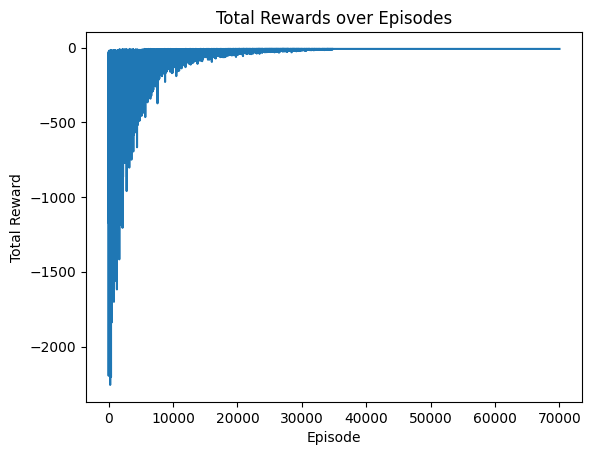

In [13]:
plt.plot(totalRewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards over Episodes')
plt.show()